In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.metrics import  classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt
from simpletransformers.language_representation import RepresentationModel
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import KFold


# Carregando base de dados  pré-processada

In [2]:
dataset = pd.read_csv("../../Database/dataBaseWithNER.csv")
dataset = dataset.drop(columns=["Unnamed: 0"])
dataset = dataset.dropna()
targets = np.array(dataset["target"].array)

dataset

,email,target
0,start date hourahead timee cardinall hou...,0
1,service long desk price structure deal quote ...,0
2,start date cardinall hourahead timee card...,0
3,start date hourahead timee cardinall anc...,0
4,cardinall deliverable revenue management marke...,0
...,...,...
33340,bio matrix scientific group symbo bmxg p...,1
33341,cardinall step away hot naked webcam girl liv...,1
33342,need pill increase performance click seroius ...,1
33343,datee final nom inlet hpl eastrans car...,0


In [3]:
emailsText = []
for email in dataset["email"]:
    emailsText.append(email)

del dataset

In [4]:
print(len(emailsText))

33341


# Representação vetorial BERT

In [5]:
model=RepresentationModel(
    model_type="bert",
    model_name="bert-base-uncased",
    use_cuda=True,
    #fp16=True
)

vectorialRepresentation = model.encode_sentences(emailsText, combine_strategy="mean")
vectorialRepresentation.shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(33341, 768)

In [6]:
bertDataframe = pd.DataFrame(vectorialRepresentation)
bertDataframe

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.159428,-0.150673,0.320971,0.112358,0.459967,0.077280,0.211645,0.108739,-0.041492,-0.183632,...,0.251432,-0.163091,-0.116690,-0.070913,-0.048259,-0.037924,-0.119490,-0.189950,-0.203662,0.074954
1,0.071051,0.006274,0.291100,-0.089434,0.006165,0.019528,0.109083,0.026950,0.204912,-0.180139,...,0.284122,-0.540412,0.049729,-0.095771,-0.203890,0.091056,-0.145161,-0.096876,-0.135908,0.060218
2,-0.151653,-0.164808,0.471539,-0.066901,0.267297,0.017360,-0.074956,0.166499,-0.042147,-0.080027,...,0.109118,-0.118454,-0.086577,-0.057226,0.129574,-0.021993,-0.200361,-0.175351,-0.030066,0.166013
3,-0.091722,-0.252287,0.291835,0.154237,0.285827,-0.033622,-0.024027,0.107403,-0.000545,-0.192616,...,0.225206,-0.128331,-0.235366,-0.151748,-0.025532,0.023671,0.072414,-0.086625,-0.004205,0.172869
4,-0.028974,-0.141580,0.607358,0.108809,0.400952,-0.087711,-0.108502,0.262436,-0.031409,-0.208465,...,-0.080698,-0.173298,0.043021,-0.124838,-0.122861,-0.152739,-0.130289,-0.272174,-0.106081,-0.142323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33336,-0.201023,-0.001996,0.590600,-0.040250,0.472595,0.059005,-0.223889,0.168916,-0.019692,-0.068533,...,-0.283789,0.086214,0.281354,0.030180,0.144887,-0.240283,-0.269940,-0.195859,-0.090531,-0.038818
33337,0.045905,-0.145504,0.600411,0.147447,0.138597,-0.070919,0.243944,0.133416,-0.177918,-0.203445,...,0.008279,-0.050800,0.085909,-0.260432,-0.009710,0.090369,-0.170151,-0.095905,-0.061700,-0.136271
33338,-0.052234,-0.027882,0.484133,0.026257,0.134670,0.035107,0.068209,0.120231,0.002479,-0.294419,...,-0.157346,-0.069377,0.014211,-0.028526,0.019504,-0.002726,-0.118924,0.022453,0.061370,0.090219
33339,-0.226833,-0.098093,0.445973,-0.028613,0.256372,0.029888,-0.050134,0.159709,0.134332,-0.035709,...,-0.012439,-0.048856,0.105855,-0.005054,0.283087,-0.077617,-0.224488,-0.029133,-0.032732,-0.195680


In [ ]:
bertData = np.array(bertDataframe)
bertData

# Visualização de dados com TSNE

In [7]:
# model = TSNE(n_components=2, random_state=0)
# array_red = model.fit_transform(bertDataframe)

# df_tsne = pd.DataFrame(array_red)

# df_tsne['Target'] = target
# print(df_tsne)

E:\DevPack\anaconda3\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\DevPack\anaconda3\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


               0          1  Target
0     -75.484505 -21.128466       0
1       1.098834 -35.483253       0
2      47.738682 -36.893559       0
3       9.928965 -70.018379       0
4      13.938590 -21.092623       0
...          ...        ...     ...
33336  22.243933  56.396641       1
33337 -31.545631 -11.026985       1
33338 -28.561445 -19.727957       1
33339  29.865818 -40.960075       0
33340 -24.992823  19.384506       1

[33341 rows x 3 columns]


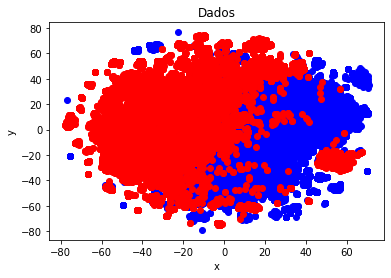

In [8]:
# df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]

# df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]

# plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')

# plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')

# plt.title('Dados')
# plt.xlabel('x')
# plt.ylabel('y')

# plt.show()

# Validação

In [ ]:
bertData = np.array(bertData)

bertData = bertData.reshape((bertData.shape[0],1,bertData.shape[1]))
print(bertData.shape)

In [ ]:
foldsAccuracy = []
foldLosses = []

In [ ]:

kfold = KFold(n_splits=4, shuffle=True)

In [ ]:
foldCount = 1
for train, test in kfold.split(bertData, targets):
    model = keras.models.Sequential([
        #keras.layers.Conv1D(1000, kernel_size=1, activation="relu",input_shape=bertData.shape[1:]),
        keras.layers.Conv1D(640, kernel_size=1, activation="relu",input_shape=bertData.shape[1:]),
        keras.layers.MaxPooling1D(pool_size=1),
        keras.layers.Flatten(),
        #keras.layers.Dense(5000, activation="relu"),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(len(set(targets)), activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

    print('****************************************************')
    print(f'Iniciando treinamento da fold: {foldCount}.')

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4,mode='min'), bertData.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)]

    history = model.fit(bertData[train], targets[train], epochs=200, callbacks=callbacks, validation_split=0.05)

    scores = model.evaluate(bertData[test], targets[test], verbose=0)
    print(f'Score fold {foldCount}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

    foldsAccuracy.append(scores[1] * 100)
    foldLosses.append(scores[0])

    foldCount = foldCount + 1

****************************************************
Iniciando treinamento da fold: 1.
Epoch 1/200
743/743 [==============================] - 4s 3ms/step - loss: 0.3499 - accuracy: 0.8889 - val_loss: 0.1727 - val_accuracy: 0.9440 - lr: 0.0100
Epoch 2/200
743/743 [==============================] - 2s 2ms/step - loss: 0.2207 - accuracy: 0.9410 - val_loss: 0.1448 - val_accuracy: 0.9528 - lr: 0.0100
Epoch 3/200
743/743 [==============================] - 2s 2ms/step - loss: 0.1933 - accuracy: 0.9501 - val_loss: 0.1184 - val_accuracy: 0.9600 - lr: 0.0100
Epoch 4/200
743/743 [==============================] - 2s 2ms/step - loss: 0.1385 - accuracy: 0.9627 - val_loss: 0.0856 - val_accuracy: 0.9712 - lr: 0.0100
Epoch 5/200
743/743 [==============================] - 2s 2ms/step - loss: 0.1287 - accuracy: 0.9648 - val_loss: 0.1275 - val_accuracy: 0.9576 - lr: 0.0100
Epoch 6/200
743/743 [==============================] - 2s 2ms/step - loss: 0.0776 - accuracy: 0.9768 - val_loss: 0.0639 - val_accurac

In [ ]:
print('****************************************************')
print('Score de cada fold:')
for i in range(0, len(foldsAccuracy)):
    print('****************************************************')
    print(f'--> Fold {i+1}: Loss: {foldLosses[i]} ; Accuracy: {foldsAccuracy[i]}%')

print('****************************************************')
print('Média de accuracy das folds:')
print(f'--> Accuracy: {np.mean(foldsAccuracy)} (+- {np.std(foldsAccuracy)})')
print(f'--> Loss: {np.mean(foldLosses)}')
print('****************************************************')